In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
import findspark
findspark.init()
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc=spark.sparkContext

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from pyspark.mllib.regression import LabeledPoint, LinearRegressionModel, LinearRegressionWithSGD
from pyspark.ml.regression import LinearRegression
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
#stringIndexer and one hot encoder for encoding
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer
from pyspark.mllib.linalg import Vector, Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

# Data Cleaning

In [0]:
cols1=['name','online_order','book_table','cuisines','rest_type','rate','approx_cost(for two people)','listed_in(city)','listed_in(type)','menu_item','votes','location']
rename=['name','online_order','book_table','rate','menu_item','approx_cost_for_two_people)','listed_in(city)','location']
data = pd.read_csv("/content/drive/My Drive/Zomato/zomato_new.csv", dtype={'rate': str}, usecols=cols1, error_bad_lines=False, warn_bad_lines=True)
data.head(11)
data.shape

(51717, 12)

In [0]:
data.rename({'approx_cost(for two people)': 'approx_cost', 'listed_in(city)': 'city', 'listed_in(type)':'type'}, axis=1, inplace=True)

In [0]:
#counting number of duplicated entries
data.duplicated().sum()

87

In [0]:
#removing duplicates
data.drop_duplicates(inplace=True)

In [0]:
#counting numbe rof null values
data.isna().sum()

name               0
online_order       0
book_table         0
rate            7759
votes              0
location          21
rest_type        227
cuisines          45
approx_cost      344
menu_item          0
type               0
city               0
dtype: int64

In [0]:
#dropping null valued rows
data.dropna(how='any', inplace=True)

In [0]:
#resetting index as droppings changed the indexes
data.reset_index(drop=True, inplace=True)

In [0]:
#finding the available unique values in rate column in order to clean this
data.rate.unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', 'NEW', '2.9/5', '3.5/5', '2.6/5', '3.8 /5', '3.4/5',
       '4.5/5', '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5',
       '3.4 /5', '-', '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5',
       '4.1 /5', '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5',
       '3.5 /5', '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5',
       '4.3 /5', '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5',
       '4.9 /5', '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

In [0]:
#replaciing rate columns /5 with empty space
for i in range(0, len(data)):
  if '/' in data.iloc[i,3]:
    #print(i)
    data.at[i,'rate']= data.iloc[i,3].split('/')[0].strip()

In [0]:
#taking only non NEW and '-' containing rows
data = data[(data.rate !='NEW') & (data.rate !='-')].reset_index(drop=True)

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41205 entries, 0 to 41204
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          41205 non-null  object
 1   online_order  41205 non-null  object
 2   book_table    41205 non-null  object
 3   rate          41205 non-null  object
 4   votes         41205 non-null  int64 
 5   location      41205 non-null  object
 6   rest_type     41205 non-null  object
 7   cuisines      41205 non-null  object
 8   approx_cost   41205 non-null  object
 9   menu_item     41205 non-null  object
 10  type          41205 non-null  object
 11  city          41205 non-null  object
dtypes: int64(1), object(11)
memory usage: 3.8+ MB


In [0]:
#removing comma in cost column to make it as an integer
remove_comma = lambda x: int(x.replace(',', '')) if type(x) == np.str and x != np.nan else x 
data['approx_cost'] = data['approx_cost'].apply(remove_comma)

In [0]:
#changing the data types of columns
dict_1={'rate': float, 'votes': int, 'approx_cost': int}
data=data.astype(dict_1)

In [0]:
data.approx_cost.unique()

array([ 800,  300,  600,  700,  550,  500,  450,  650,  400,  900,  200,
        750,  150,  850,  100, 1200,  350,  250,  950, 1000, 1500, 1300,
        199, 1100, 1600,  230,  130, 1700, 1350, 2200, 1400, 2000, 1800,
       1900,  180,  330, 2500, 2100, 3000, 2800, 3400,   50,   40, 1250,
       3500, 4000, 2400, 2600, 1450,   70, 3200,  240, 6000, 1050, 2300,
       4100,  120, 5000, 3700, 1650, 2700, 4500,   80])

In [0]:
#converting first letter of each word into capital letters
data.name = data.name.apply(lambda x:x.title())

In [0]:
#converting the cleaned data into csv
data.to_csv('temp.csv')

In [0]:
#thish for simple encoding but not needed
def Encode(data):
    for column in data.columns[~data.columns.isin(['rate', 'approx_cost', 'votes'])]:
        data[column] = data[column].factorize()[0]
    return data

data_encoded = Encode(data.copy())

In [0]:
data_encoded.head(10)

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost,menu_item,type,city
0,0,0,0,4.1,775,0,0,0,800,0,0,0
1,1,0,1,4.1,787,0,0,1,800,0,0,0
2,2,0,1,3.8,918,0,1,2,800,0,0,0
3,3,1,1,3.7,88,0,2,3,300,0,0,0
4,4,1,1,3.8,166,1,0,4,600,0,0,0
5,5,0,1,3.8,286,1,0,5,600,0,0,0
6,6,1,1,3.6,8,2,0,6,800,0,0,0
7,7,0,0,4.6,2556,0,3,7,600,0,1,0
8,8,0,1,4.0,324,0,4,8,700,0,1,0
9,9,0,1,4.2,504,0,4,9,550,0,1,0


In [0]:
#converting into csv
data_encoded.to_csv('encoded.csv')

#Encoding

In [0]:
data_new_dtr=spark.read.csv("temp.csv", header=True, inferSchema=True)

In [0]:
categorical_variables = ['online_order', 'book_table', 'location', 'rest_type', 'cuisines','type']

indexers = [StringIndexer(inputCol=column, outputCol=column+"-index") for column in categorical_variables]

encoder = OneHotEncoderEstimator(
    inputCols=[indexer.getOutputCol() for indexer in indexers],
    outputCols=["{0}-encoded".format(indexer.getOutputCol()) for indexer in indexers]
)

assembler = VectorAssembler(
    inputCols=encoder.getOutputCols(),
    outputCol="categorical-features"
)


pipeline = Pipeline(stages=indexers + [encoder, assembler])
data_new_dtr = pipeline.fit(data_new_dtr).transform(data_new_dtr)

In [0]:
continuous_variables = ['votes', 'rate']
assembler = VectorAssembler(
    inputCols=['categorical-features', *continuous_variables],
    outputCol='features'
)
data_new_dtr = assembler.transform(data_new_dtr)

In [0]:
data_new_dtr=data_new_dtr.withColumnRenamed("approx_cost","label")

In [0]:
(trainingData_1, testData_1) = data_new_dtr.randomSplit([0.7, 0.3])

# Linear Regression

In [0]:
regressor=LinearRegression(featuresCol="features",labelCol="label", regParam=2)
regressor1=regressor.fit(trainingData_1)
pred_res=regressor1.evaluate(testData_1)

In [0]:
#test accuracy
pred_res.r2

0.8988751267964183

In [0]:
#training accuracy
regressor1.summary.r2

0.9080842362419623

In [0]:
pred_res.predictions.select('prediction','label').show()

+------------------+-----+
|        prediction|label|
+------------------+-----+
| 760.6433390357112|  600|
| 542.5919390487036|  550|
| 781.4307217882235|  800|
|332.89828246549723|  400|
| 572.4488150596763|  900|
| 470.1813804530178|  600|
|170.06085319437364|  200|
| 556.5246392533943|  550|
|485.58766473269566|  500|
| 678.1861165017069|  600|
|169.25648584772932|  300|
|426.15388116840836|  500|
|  484.893317743035|  800|
| 565.3548244154886|  600|
| 306.2085863411402|  450|
| 443.2864926600407|  450|
| 337.8694144383106|  400|
| 788.8203664391926|  800|
|239.61173074102476|  150|
|480.76507118973984|  500|
+------------------+-----+
only showing top 20 rows



In [0]:
regressor1.summary.totalIterations

1

# Decision Tree

In [0]:
featureIndexer =VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=20).fit(data_new_dtr)

In [0]:

    # Train a DecisionTree model.
dt = DecisionTreeRegressor(featuresCol="indexedFeatures")

    # Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, dt])

    # Train model.  This also runs the indexer.
model = pipeline.fit(trainingData_1)

    # Make predictions.
predictions = model.transform(testData_1)

    # Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

   


+-----------------+-----+--------------------+
|       prediction|label|            features|
+-----------------+-----+--------------------+
|551.4265739130435|  600|(3005,[1,26,94,11...|
|551.4265739130435|  550|(3005,[0,1,21,95,...|
|551.4265739130435|  800|(3005,[0,1,21,114...|
|551.4265739130435|  400|(3005,[0,1,21,95,...|
|551.4265739130435|  900|(3005,[1,21,95,20...|
+-----------------+-----+--------------------+
only showing top 5 rows



In [0]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2")
accuracy = evaluator.evaluate(predictions)
print("Accuracy on test data = %g" % accuracy)
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("RMSE  on test data = %g" % rmse)

treeModel = model.stages[1]
# summary only
print(treeModel)

Accuracy on test data = 0.627115
RMSE  on test data = 283.398
DecisionTreeRegressionModel (uid=DecisionTreeRegressor_9c9c1224e8fe) of depth 5 with 59 nodes


# Random Forest Regression

In [0]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [0]:
rand_for_reg=RandomForestRegressor(featuresCol='features', labelCol='label')
model_rand_for_reg=rand_for_reg.fit(trainingData_1)

In [0]:
pred_rand_for_reg=model_rand_for_reg.transform(testData_1)

In [0]:
pred_rand_for_reg.select('prediction','label').show(10)

+-----------------+-----+
|       prediction|label|
+-----------------+-----+
|594.0276503683504|  600|
|585.9756779307113|  550|
|600.9772072885601|  800|
|490.5085279238457|  400|
|490.5085279238457|  900|
|490.5085279238457|  600|
|490.5085279238457|  200|
|490.5085279238457|  550|
|477.0198535432775|  500|
|663.2591091821034|  600|
+-----------------+-----+
only showing top 10 rows



In [0]:
#root mean square error
evaluator= RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName="r2")
accuracy=evaluator.evaluate(pred_rand_for_reg)
evaluator= RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName="rmse")
rmse=evaluator.evaluate(pred_rand_for_reg)

In [0]:
print("Accuracy on test data = ", float(accuracy)*100)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Accuracy on test data =  68.0863519206153
Root Mean Squared Error (RMSE) on test data = 262.179


# Gradient-Boosted Tree regression

In [0]:
#gradient boosted tree regression
gbtr_reg=GBTRegressor(featuresCol='features',labelCol='label')
model_gbtr=gbtr_reg.fit(trainingData_1)

In [0]:
pred_gbtr_reg=model_gbtr.transform(testData_1)
evaluater_gbtr=RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')
r_square=evaluater_gbtr.evaluate(pred_gbtr_reg)
print("The accuracy is ",r_square)

The accuracy is  0.7736912384885062


# Some Visualizations

In [0]:
data_vis=pd.read_csv('encoded.csv')

Index(['Unnamed: 0', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'location', 'rest_type', 'cuisines', 'approx_cost', 'menu_item', 'type',
       'city'],
      dtype='object')

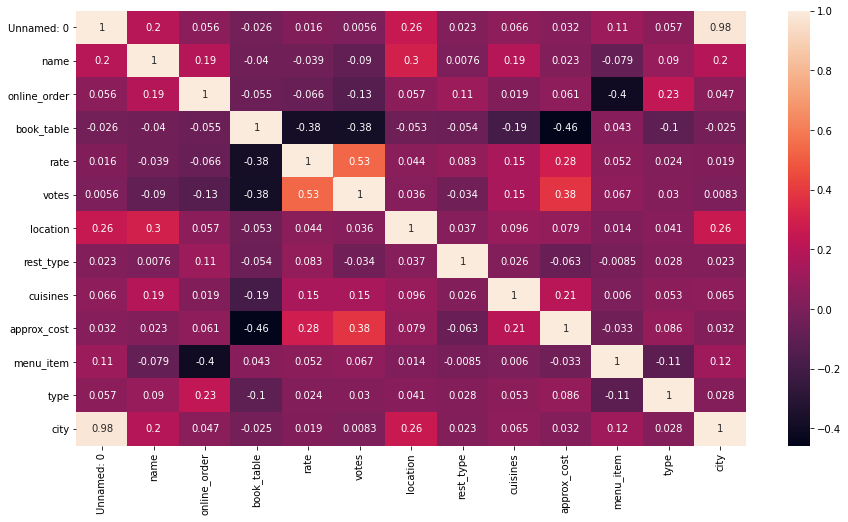

In [0]:
#Get Correlation between different variables
corr = data_vis.corr(method='kendall')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)
data_vis.columns

Text(0.5, 1.0, 'Restaurants delivering online or Not')

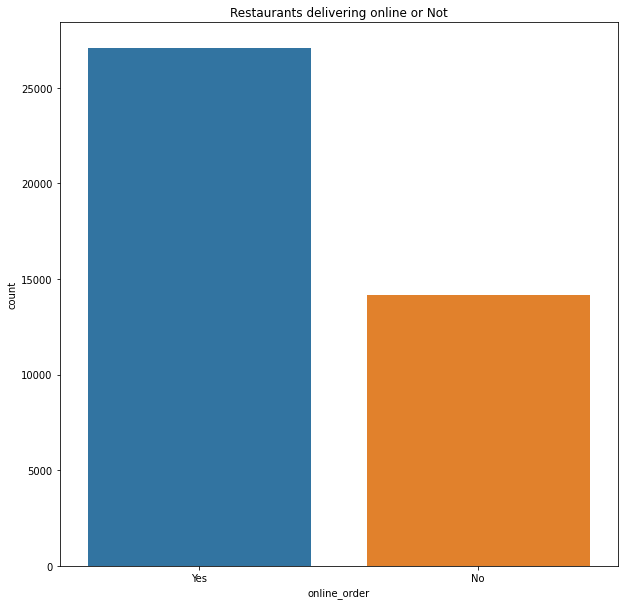

In [0]:
#Restaurants delivering Online or not
sns.countplot(data['online_order'])
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.title('Restaurants delivering online or Not')

Text(0.5, 1.0, 'Restaurants allowing table booking or not')

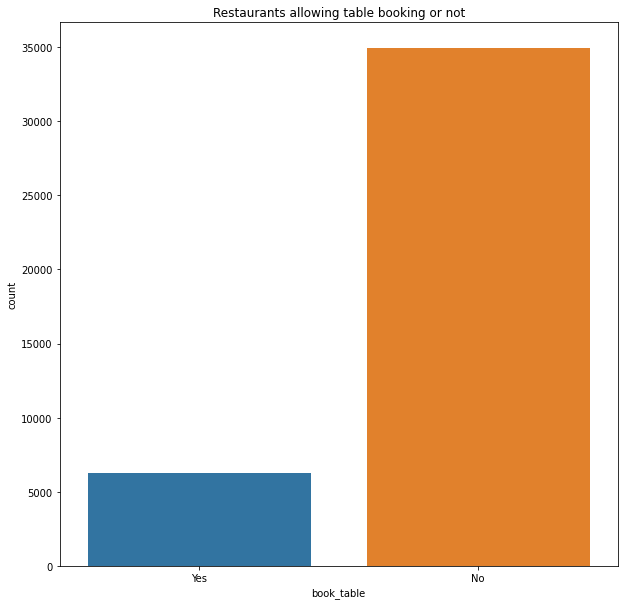

In [0]:
#Restaurants allowing table booking or not
sns.countplot(data['book_table'])
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.title('Restaurants allowing table booking or not')

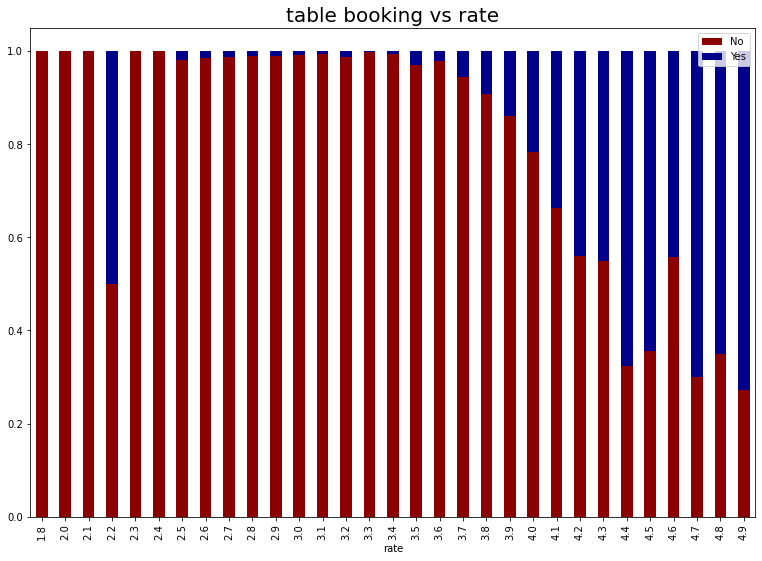

In [0]:
#Table booking Rate vs Rate
plt.rcParams['figure.figsize'] = (13, 9)
Y = pd.crosstab(data['rate'], data['book_table'])
Y.div(Y.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True,color=['darkred','darkblue'])
plt.title('table booking vs rate', fontweight = 30, fontsize = 20)
plt.legend(loc="upper right")
plt.show()

Text(0.5, 1.0, 'Location')

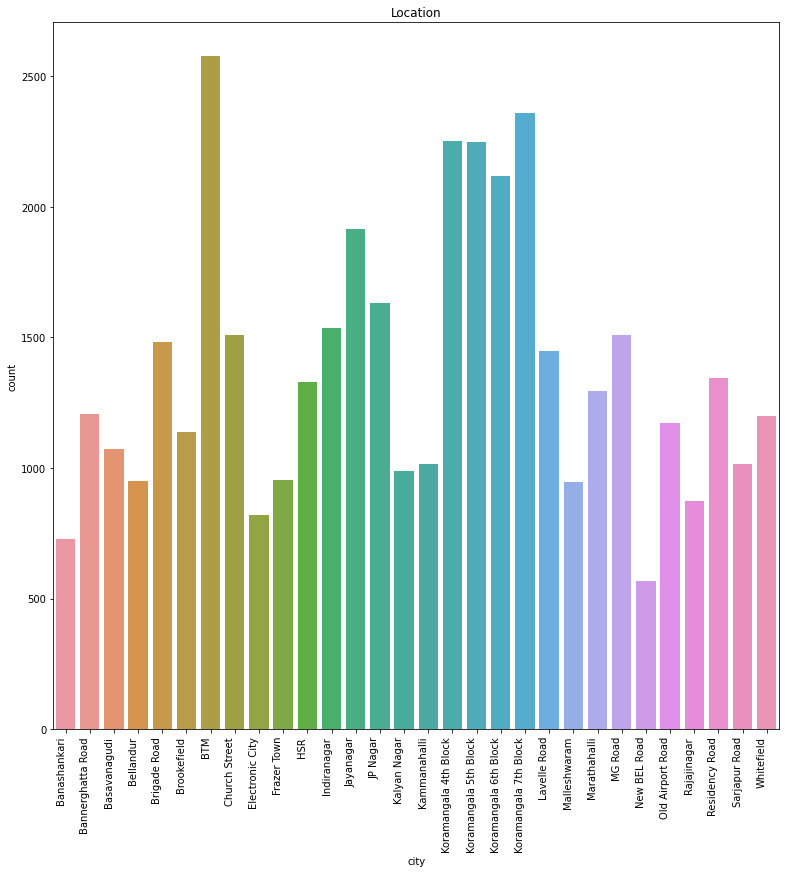

In [0]:
# Location
sns.countplot(data['city'])
sns.countplot(data['city']).set_xticklabels(sns.countplot(data['city']).get_xticklabels(), rotation=90, ha="right")
fig = plt.gcf()
fig.set_size_inches(13,13)
plt.title('Location')

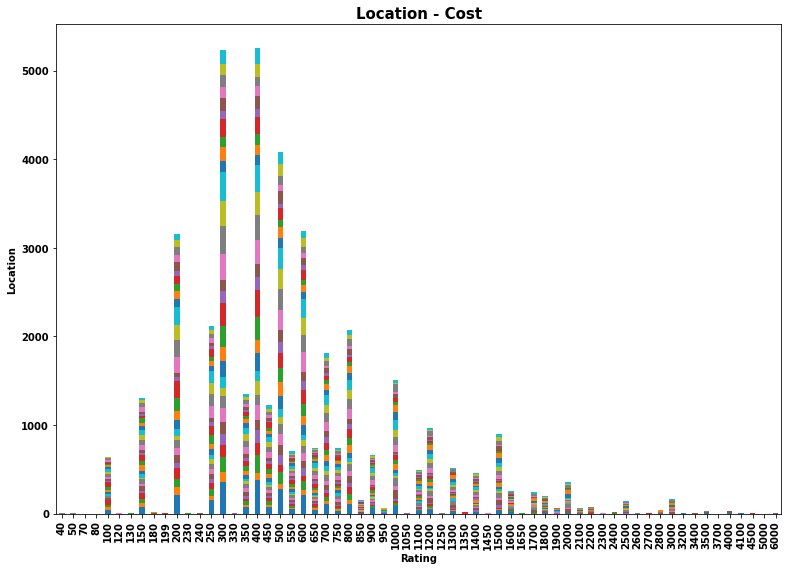

In [0]:
#Location and Rating
loc_plt=pd.crosstab(data['approx_cost'],data['city'])
loc_plt.plot(kind='bar',stacked=True);
plt.title('Location - Cost',fontsize=15,fontweight='bold')
plt.ylabel('Location',fontsize=10,fontweight='bold')
plt.xlabel('Rating',fontsize=10,fontweight='bold')
plt.xticks(fontsize=10,fontweight='bold')
plt.yticks(fontsize=10,fontweight='bold');
plt.legend().remove();

Text(0.5, 1.0, 'Restuarant Type')

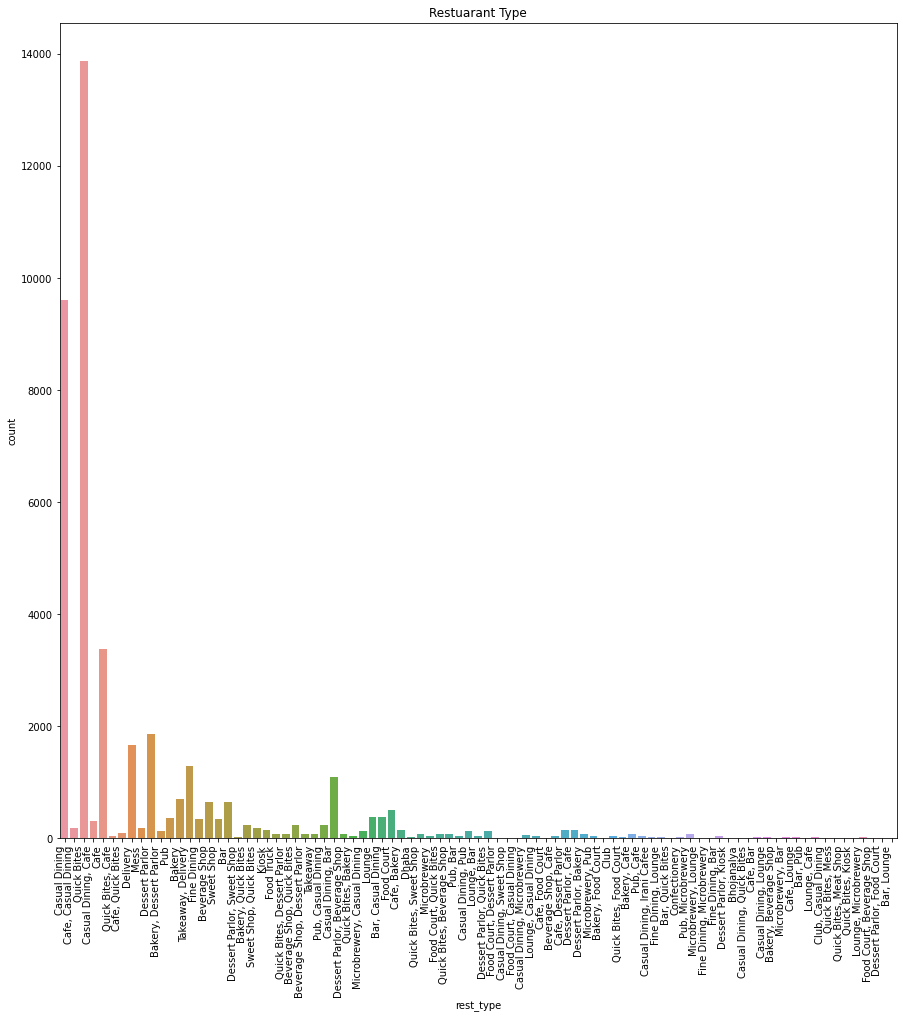

In [0]:
#Restaurant Type
sns.countplot(data['rest_type'])
sns.countplot(data['rest_type']).set_xticklabels(sns.countplot(data['rest_type']).get_xticklabels(), rotation=90, ha="right")
fig = plt.gcf()
fig.set_size_inches(15,15)
plt.title('Restuarant Type')

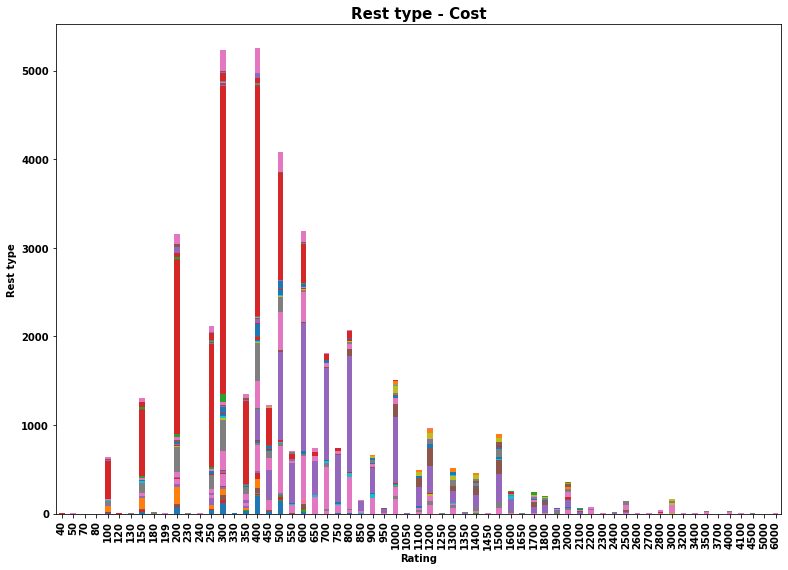

In [0]:
#Gaussian Rest type and Rating
loc_plt=pd.crosstab(data['approx_cost'],data['rest_type'])
loc_plt.plot(kind='bar',stacked=True);
plt.title('Rest type - Cost',fontsize=15,fontweight='bold')
plt.ylabel('Rest type',fontsize=10,fontweight='bold')
plt.xlabel('Rating',fontsize=10,fontweight='bold')
plt.xticks(fontsize=10,fontweight='bold')
plt.yticks(fontsize=10,fontweight='bold');
plt.legend().remove();

Text(0.5, 1.0, 'Type of Service')

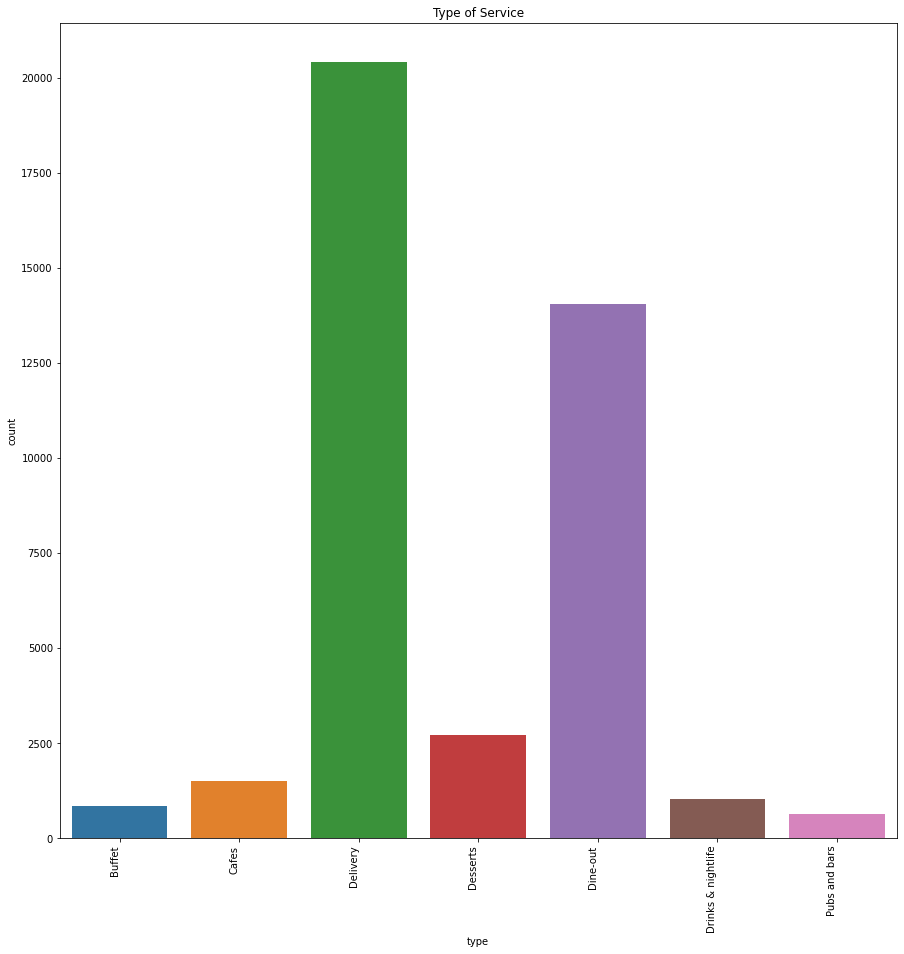

In [0]:
#Types of Services
sns.countplot(data['type'])
sns.countplot(data['type']).set_xticklabels(sns.countplot(data['type']).get_xticklabels(), rotation=90, ha="right")
fig = plt.gcf()
fig.set_size_inches(15,15)
plt.title('Type of Service')

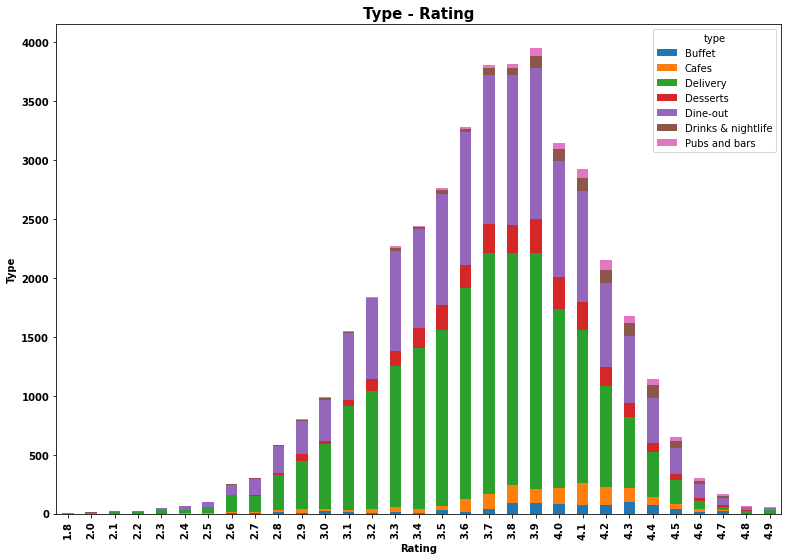

In [0]:
#Type and Rating
type_plt=pd.crosstab(data['rate'],data['type'])
type_plt.plot(kind='bar',stacked=True);
plt.title('Type - Rating',fontsize=15,fontweight='bold')
plt.ylabel('Type',fontsize=10,fontweight='bold')
plt.xlabel('Rating',fontsize=10,fontweight='bold')
plt.xticks(fontsize=10,fontweight='bold')
plt.yticks(fontsize=10,fontweight='bold');

Text(0.5, 1.0, 'Cost of Restaurant')

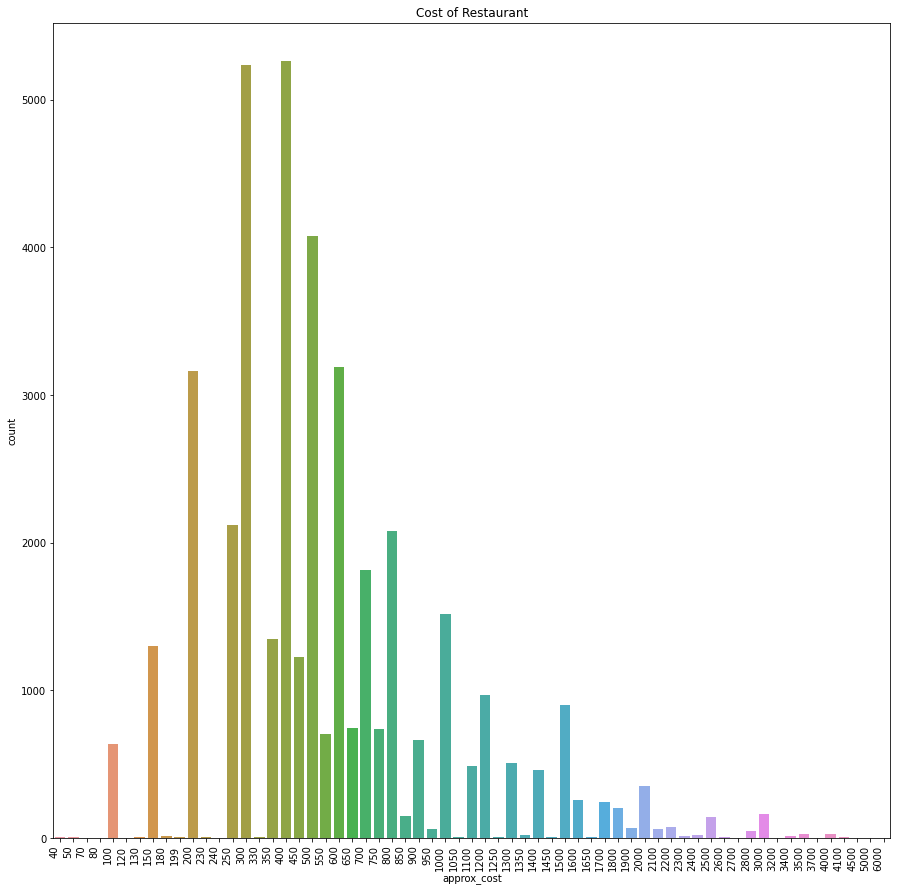

In [0]:
#Cost of Restuarant
sns.countplot(data['approx_cost'])
sns.countplot(data['approx_cost']).set_xticklabels(sns.countplot(data['approx_cost']).get_xticklabels(), rotation=90, ha="right")
fig = plt.gcf()
fig.set_size_inches(15,15)
plt.title('Cost of Restaurant')

Text(0.5, 1.0, 'NO. of restaurants in a Location')

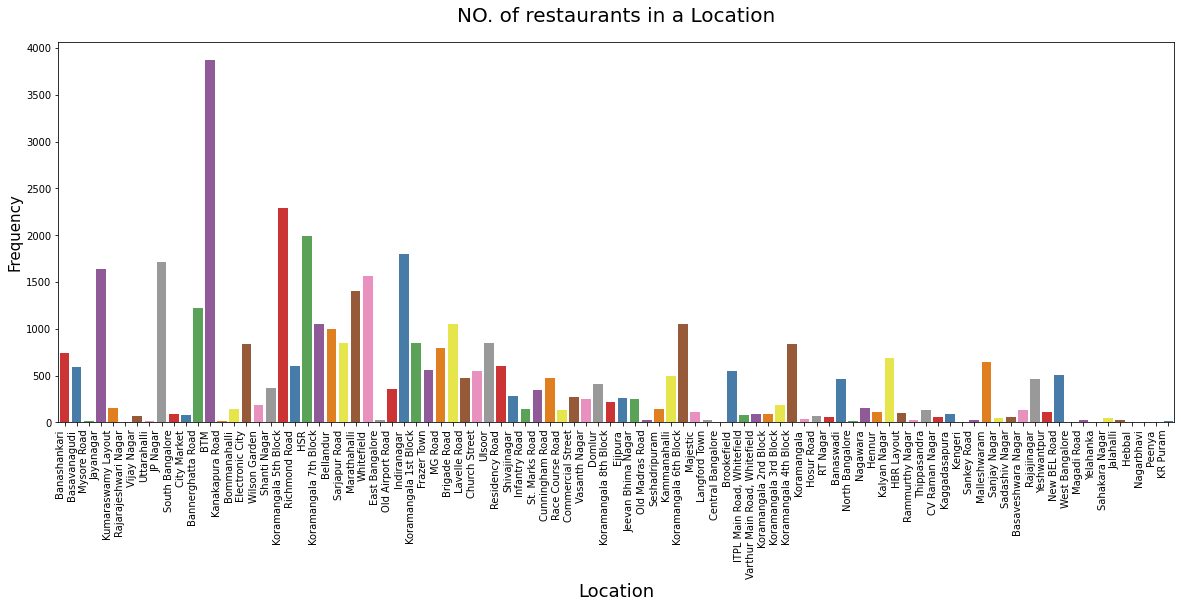

In [0]:
#NO. of restaurants in a Location',
fig = plt.figure(figsize=(20,7))
loc = sns.countplot(x="location",data=data, palette = "Set1")
loc.set_xticklabels(loc.get_xticklabels(), rotation=90, ha="right")
plt.ylabel("Frequency",size=15)
plt.xlabel("Location",size=18)
loc
plt.title('NO. of restaurants in a Location',size = 20,pad=20)

Text(0.5, 1.0, 'Restaurant types')

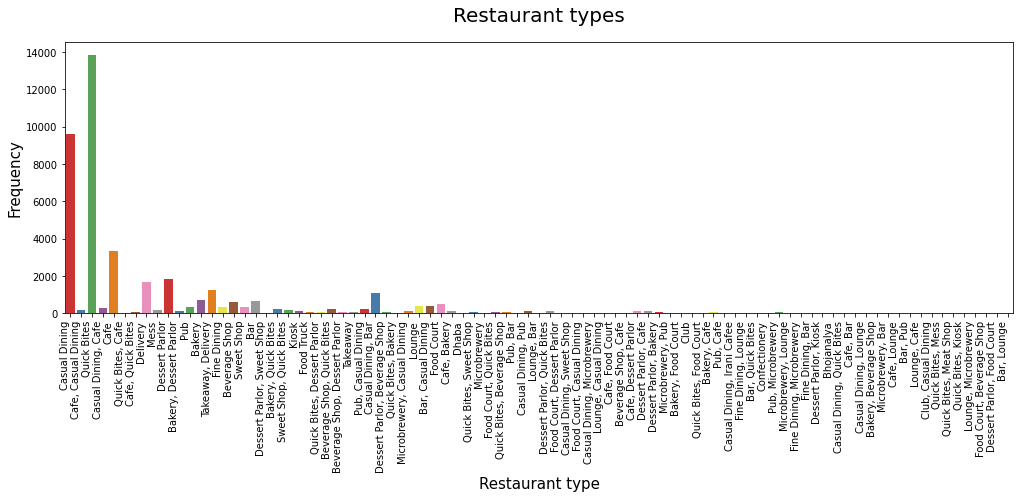

In [0]:
#Restaurant type
fig = plt.figure(figsize=(17,5))
rest = sns.countplot(x="rest_type",data=data, palette = "Set1")
rest.set_xticklabels(rest.get_xticklabels(), rotation=90, ha="right")
plt.ylabel("Frequency",size=15)
plt.xlabel("Restaurant type",size=15)
rest 
plt.title('Restaurant types',fontsize = 20 ,pad=20)

Text(0.5, 0, 'Number of outlets')

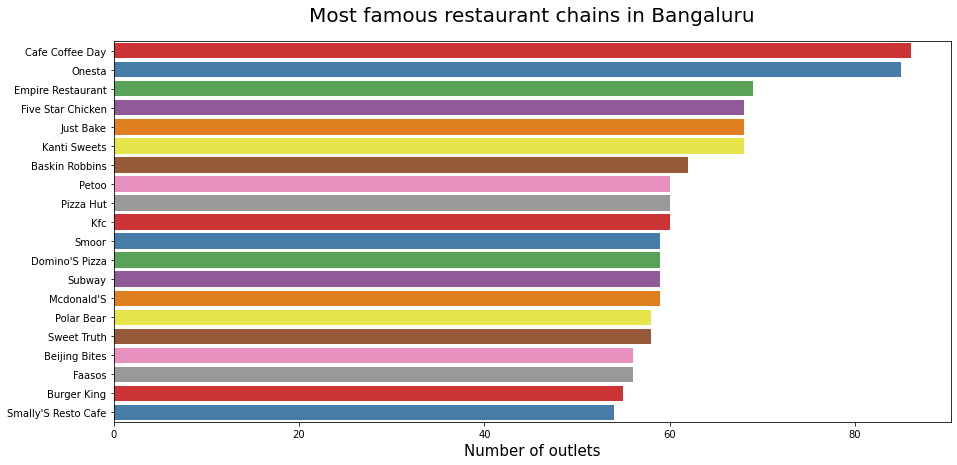

In [0]:
#Most famous restaurant chains in Bengaluru
plt.figure(figsize=(15,7))
chains=data['name'].value_counts()[:20]
sns.barplot(x=chains,y=chains.index,palette='Set1')
plt.title("Most famous restaurant chains in Bangaluru",size=20,pad=20)
plt.xlabel("Number of outlets",size=15)